In [1]:
import functools

from qdrant_client import QdrantClient

from langchain_groq import ChatGroq
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

import torch
from transformers import AutoModel
from FlagEmbedding import BGEM3FlagModel

from RAGModule.retrieve import retrieve_relevant_chunks

from GraphModule.chains import query_analyzer_chain, rewriter_chain, responder_chain
from GraphModule.pydantic_models import State
from GraphModule.nodes import *
from GraphModule.routes import *

from llm_compiler.utils import *
from llm_compiler.runnables import *
from llm_compiler.prompts import llm_compiler_prompt, joiner_prompt
from llm_compiler.pydantic_models import JoinOutputs

torch.set_grad_enabled(False)

from dotenv import load_dotenv
load_dotenv()

/home/taiquach123471/anaconda3/envs/insomnia_chatbot_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
client = QdrantClient("http://localhost:6333")
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)
bge_m3 = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
jina_v3 = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True).to('cuda')

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 148910.20it/s]
/home/taiquach123471/anaconda3/envs/insomnia_chatbot_v2/lib/python3.11/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issu

In [3]:
retrieve_relevant_chunks = functools.partial(retrieve_relevant_chunks, jina_embedding = jina_v3, bge_embedding = bge_m3, client = client)

@tool
def retrieve_chunks(query: str) -> str:
    """retrieve_chunks(query="the search query") - This tool retrieves relevant information from a vector store containing insomnia-related data based on the given query"""
    relevant_chunks = retrieve_relevant_chunks(query=query)
    relevant_chunks = format_chunks(relevant_chunks[:3])
    return relevant_chunks
tools = [retrieve_chunks]

In [4]:
planner = create_planner(llm, tools, llm_compiler_prompt)

In [5]:
runnable = joiner_prompt | llm.with_structured_output(JoinOutputs)
joiner_chain = select_recent_messages | runnable

In [6]:
#query = "Common causes of insomnia in teenagers and the role of caffeine in contributing to insomnia in teenagers"
#tool_messages = plan_and_schedule.invoke({"llm_compiler_messages": [HumanMessage(content=query)]})['llm_compiler_messages']
#tool_messages

In [7]:
#res = runnable.invoke({"llm_compiler_messages": [HumanMessage(content=query)] + tool_messages})
#res

In [8]:
@as_runnable
def plan_and_schedule(state: State):
    messages = state["llm_compiler_messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"llm_compiler_messages": scheduled_tasks}


def joiner(state: State):
    join_outputs: JoinOutputs = joiner_chain.invoke({"llm_compiler_messages": state["llm_compiler_messages"]})
    join_outputs.should_replan = False ### Temporary not using Replan

    if join_outputs.should_replan:
        return {"llm_compiler_messages":[AIMessage(content = f"Thought: {join_outputs.thought}")] +  [SystemMessage(content = join_outputs.replan_analysis)]}
    else:
        messages = state["llm_compiler_messages"]
        documents = ''
        for msg in messages[::-1]:
            if isinstance(msg, HumanMessage):
                break
            if msg.name == 'join':
                continue
            documents += msg.content + '\n\n'
        
        return {"documents": documents}

In [9]:
graph_builder = StateGraph(State)

graph_builder.add_node("query_analyzer", query_analyzer)
graph_builder.add_node("rewriter", rewriter)
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("joiner", joiner)
graph_builder.add_node("ask_human", ask_human)
graph_builder.add_node("responder", generate_response)

graph_builder.add_edge(START, "query_analyzer")
graph_builder.add_conditional_edges("query_analyzer", query_analyzer_route, {"rewriter": "rewriter", "responder": "responder"})
graph_builder.add_conditional_edges("rewriter", rewriter_route, {"ask_human": "ask_human", "llm_compiler": "plan_and_schedule"})
graph_builder.add_conditional_edges("joiner", compiler_route, {"plan_and_schedule": "plan_and_schedule", "responder": "responder"})
graph_builder.add_edge("ask_human", "rewriter")
graph_builder.add_edge("plan_and_schedule", "joiner")
graph_builder.add_edge("responder", END)

In [10]:
graph = graph_builder.compile(checkpointer=MemorySaver(), interrupt_before=["ask_human"])

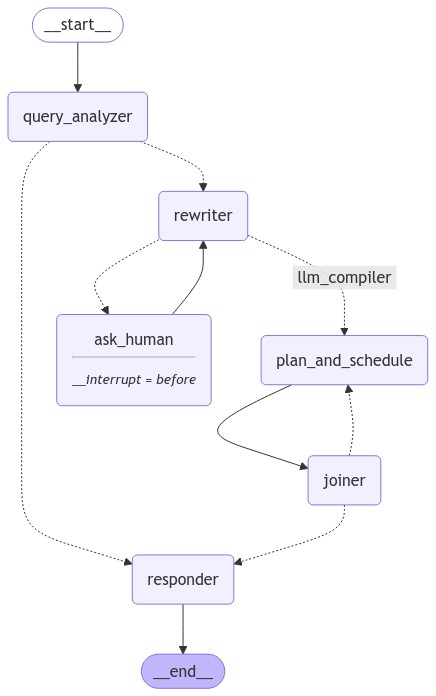

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
config = {"configurable": {"thread_id": 0}}

In [ ]:
query = "Tell me some common causes of insomnia in teenagers. Does caffeine one of them?"
for event in graph.stream({"messages": [HumanMessage(content=query)]}, config = config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Tell me some common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={})], 'llm_compiler_messages': []}
{'messages': [HumanMessage(content='Tell me some common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={})], 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': []}
{'messages': [HumanMessage(content='Tell me some common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response='What are the most common causes of insomnia in teenagers, and is caffeine consumption one of them?', need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': [HumanMessage(content='What are the most common causes of insomnia in teenagers, and is caffeine consumption one of them?', additional_kwargs={}, r

Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'messages': [HumanMessage(content='Tell me some common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response='What are the most common causes of insomnia in teenagers, and is caffeine consumption one of them?', need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': [HumanMessage(content='What are the most common causes of insomnia in teenagers, and is caffeine consumption one of them?', additional_kwargs={}, response_metadata={}), FunctionMessage(content='---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/ijerph-18-12389.md\ndoc_id:63250589-0e64-4fc4-b01c-f0217883214e\nTitle: Effects of Caffeine and Caffeinated Beverages in Children, Adolescents and Young Adults: Short Review\n\nContent:\nNumerous studies have pointed out the adverse health effects of EDs and their connection to destructive behaviors. ED consumption is also widespread am

In [13]:
is_first = True
while True:
    query = input()
    HumanMessage(query).pretty_print()

    if query == "q":
        break

    try:
        if graph.get_state(config).next[0] == 'ask_human':
            is_first = False
            graph.update_state(config, {"messages": [HumanMessage(content = query)]}, as_node="ask_human")
    except:
        pass
        
        
    
    for event in graph.stream({"messages": [HumanMessage(content = query)]} if is_first else None, config=config, stream_mode="values"):
        pass
    
    print(graph.get_state(config).values['messages'][-1].pretty_print())

================================ Human Message =================================

Tell me bad effects of caffeine


Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


================================== Ai Message ==================================

Caffeine can have several negative effects, especially when consumed in excess or by certain individuals. Some of the potential side effects of caffeine include:

1. **Increased heart rate and blood pressure**: Caffeine can cause an increase in heart rate and blood pressure, which can be problematic for people with pre-existing heart conditions [doc_id:78db921d-6545-46d7-b345-ddfb38898886].
2. **Sleep disturbances**: Consuming caffeine in large amounts or too close to bedtime can disrupt sleep patterns and reduce the quality of sleep [doc_id:78db921d-6545-46d7-b345-ddfb38898886].
3. **Anxiety and jitteriness**: Caffeine can cause feelings of anxiety, jitteriness, and an increased sense of alertness, which can be uncomfortable for some people [doc_id:78db921d-6545-46d7-b345-ddfb38898886].
4. **Addiction**: Caffeine is a mildly addictive substance, and regular consumption can lead to physical dependence [do